# Navigation Project Report

---

## 1. Start the Environment

Initiate [Banana Collector](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector) environment. If the code cell below returns an error, please revisit the project instructions to update and reinstall [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md#installation).

In [1]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="/home/peyman/Projects/deep-reinforcement-learning/p1_navigation/Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 



### Environment description:

1. Reward
   - A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of your agent is to collect as many yellow bananas as possible while avoiding blue bananas.
2. State representation
   - The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around the agent's forward direction. 
3. Action abstraction
   - Four discrete actions are available, corresponding to:
        - 0: move forward.
        - 1: move backward.
        - 2: turn left.
        - 3: turn right.
4. Goal:
    - To solve the environment, the agent must get an average score of +13 over 100 consecutive episodes.

## 2. Importing dependencies

Import PyTorch and other dependencies for RL training.

In [8]:
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

## 3. Examine the State and Action Spaces

Run the code cell below to print some information about the environment. 

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we use the first brain available.

In [9]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [0.         1.         0.         0.         0.72253829 1.
 0.         0.         0.         0.04995839 1.         0.
 0.         0.         0.99393165 1.         0.         0.
 0.         0.42544419 0.         0.         1.         0.
 0.30007124 1.         0.         0.         0.         0.12359298
 1.         0.         0.         0.         0.03675031 0.
 0.        ]
States have length: 37


## 4. DQN Agent

The next code cell initiates a DQN agent with 37 inputs and 4 output actions corresponding to the state-action space in Banana collector environment. The agent implements the vanilla DQN based on the [nature paper](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf), where convolutional networks are replaced by fully connected networks.

- The deep neural network has the following structure:
 - Fully connected layer + ReLU: input: 37 (state size) output: 32
 - Fully connected layer + ReLU: input: 32 output 32
 - Fully connected layer + ReLU: input: 32 output: 4 (action size)
- Training parameters:
 - Maximum steps per episode: 1000
 - Starting epsilion: 1.0
 - Ending epsilion: 0.01
 - Epsilion decay rate: 0.995

In [10]:
from dqn_agent import Agent

agent = Agent(state_size=37, action_size=4, hidden_layers= [32,32], seed=0)

## 5. Pre-training test

The next code cells provide a function to test the agent implementation before starting the training process. Later, the evaluation function will also be used to test the trained agent.

In [11]:
def eval_agent(agent,train_mode):
    """Evaluate generic agent
    
    Params
    ======
        agent (Agent): agent under evaluation
        train_mode (bool): train_mode for setting UnityEnvironment 

    Returns
    ======
        score (float): the accumulated reward
    """
    env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state)                      # pass state to agent and get action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    return score

Evaluate the initial agent. Since the agent is initialized randomly, the performance is quivalant to taking random action.

In [6]:
for episod in range(10):
    score = eval_agent(agent=agent,train_mode=True) # to speed up the evaluation, set train_mode=True
    print("Score: {}".format(score))

Score: 0.0
Score: -1.0
Score: 2.0
Score: 1.0
Score: 0.0
Score: -1.0
Score: 0.0
Score: 0.0
Score: 5.0
Score: 0.0


## 6. DQN Training

The next code cell trains the agent. The training terminates when the average score exceeds 17 point or if the number of episodes reaches to `n_episodes` (set to 2000 here). The final model will be saved in `checkpoint.pth`.

In [ ]:
def train_dqn_agent(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]            
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]   
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]                  
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>17.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break
    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

scores = train_dqn_agent()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

```
Episode 100     Average Score: 0.53
Episode 200     Average Score: 3.04
Episode 300     Average Score: 7.31
Episode 400     Average Score: 9.53
Episode 500     Average Score: 12.25
Episode 600     Average Score: 14.07 --> (13+ average score in less than 600 episodes)
Episode 700     Average Score: 14.71
Episode 800     Average Score: 15.47
Episode 900     Average Score: 15.98
Episode 1000	Average Score: 16.28
Episode 1100	Average Score: 16.39
Episode 1200	Average Score: 16.39
Episode 1300	Average Score: 16.42
Episode 1400	Average Score: 16.44
Episode 1500	Average Score: 16.34
Episode 1600	Average Score: 16.31
Episode 1700	Average Score: 16.34
Episode 1800	Average Score: 16.60
Episode 1900	Average Score: 16.96
Episode 2000	Average Score: 16.29
```

![Training result](./training_plot.png)

## 7. Post-training evaluation

In the next code cell, we evaluate the agent perforamce after training.

Episode 100	Average Score: 15.48
Episode 200	Average Score: 16.62
Episode 300	Average Score: 16.36


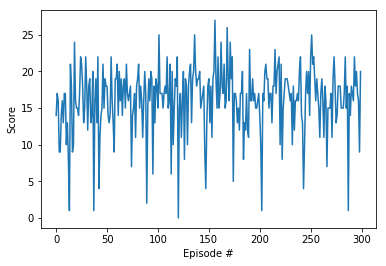

In [12]:
def eval_dqn_agent(n_episodes=300, max_t=1000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):          
        score = eval_agent(agent=agent,train_mode=True)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    return scores

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('banana-32-32-checkpoint.pth'))

# evaluate the trained DQN agent
scores = eval_dqn_agent()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Close the environment:

In [ ]:
env.close()

## 8. Ideas for future work

1. Extensive hyperparameter optimization
2. Double Deep Q Networks
3. Prioritized Experience Replay
4. Dueling Deep Q Networks
5. RAINBOW Paper
6. Learning from pixels